building grid stimsets for use with DMD. Sequence optimization is based on solution to traveling salesman problem discussed here: https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy
Thanks to the Stack Overflow community.

In [1]:
from stimset_builder import *

In [2]:
##Create a sequence of rectangular stimuli corresponding to specified grid dimension.
##Plotted in 1024x1024 'camera space' with margins that correspond to borders of DMD (manually measured and spec'd in code)
grid_stims = draw_all_grid_rects(n_cols=12, n_rows=10)

In [3]:
##make an array of center of masses
coms = image_sequence_com(grid_stims)
coms = np.array(coms)

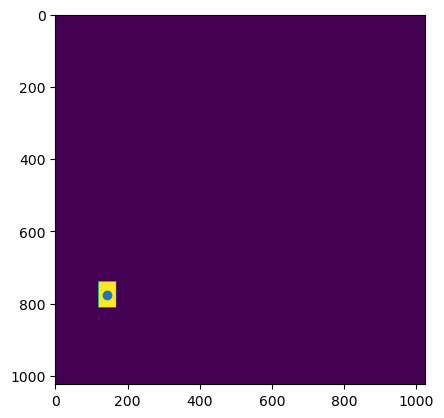

In [4]:
i=100
plt.imshow(grid_stims[:,:,i].T)
plt.scatter(coms[i][0], coms[i][1])

In [5]:
## design photostim order to minimize distance (i.e. traveling salesman)
## will not use this, except for comparison to maximized distance order
short_route = two_opt(coms,0.001)


In [6]:
def plot_route(route, coms):
    route_ix=[]
    for i in np.arange(len(route)):
        route_ix.append(list(route).index(i))

    new_route_order = np.concatenate((np.array([coms[route[i]] for i in range(len(route))]),np.array([coms[0]])))
    fig, ax = plt.subplots()
    sc = ax.scatter(coms[:,0],coms[:,1], c=route_ix, cmap='brg', zorder=5, s=100)
    # Plot the path.
    ax.plot(new_route_order[:,0],new_route_order[:,1], zorder=0, c='black', lw=1)
    fig.colorbar(sc)
    plt.show()
    # Print the route as row numbers and the total distance travelled by the path.
    print("Route: " + str(route) + "\n\nDistance: " + str(path_distance(route,coms)))

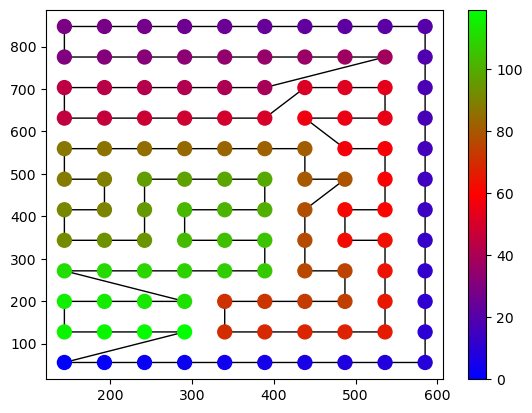

Route: [  0   1   2   3   4   5   6   7   8   9  19  29  39  49  59  69  79  89
  99 109 119 118 117 116 115 114 113 112 111 110 100 101 102 103 104 105
 106 107 108  95  94  93  92  91  90  80  81  82  83  84  85  96  97  98
  88  87  86  77  78  68  58  57  47  48  38  28  18  17  16  15  14  24
  25  26  27  37  36  46  56  67  66  76  75  74  73  72  71  70  60  61
  51  50  40  41  42  52  62  63  64  65  55  54  53  43  44  45  35  34
  33  32  31  30  23  22  21  20  10  11  12  13]

Distance: 7120.332739602971


In [7]:
plot_route(short_route, coms)

In [8]:
long_route = two_opt_long(coms,0.0001)

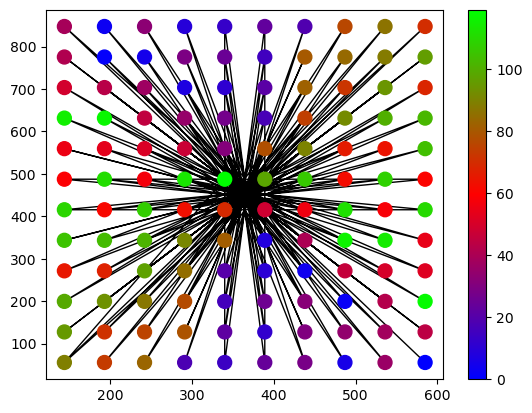

Route: [  9 101  27 111  36 102   7  93  45 113  35  94  15 114   4 105  24  85
   3 116  34  95  14 115   5 104  25  84   6 103  16  74  26 112  17  83
   8  92  18 110  46 100  28  91  19  82  37  73  55  90  38  72  39  71
  49  70  56  62  58  60  69  51  67  53  78  30  77  31  99  54 119  11
  97   1  86  12 117  23  75  13 106  44  96   2 107  33 118  22 108   0
  76  43  87  21  98  10 109  32  65  20  88  42  89  41  79  40  66  52
  68  50  59  61  57  63  48  80  47  81  29  64]

Distance: 63391.19478178264


In [9]:
plot_route(long_route, coms)

In [10]:
##long route tends to take long steps back and forth so that point n+2 is near point n. Try to avoid...
non_adj_route = two_opt_one_two_step(coms, 0.0001)

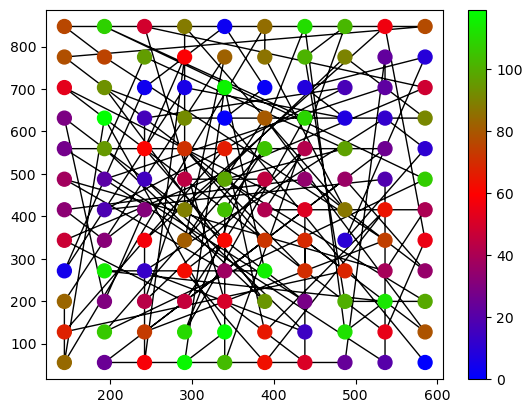

Route: [  9  84  95 114  92  30  93  87  96 109  47  79  88  32  16  62  82  97
  51  68   8  61  98 108   7   1  78  70  26  80  21  52  41  50  66  39
  67  34  60  38  59  55  76  22  63  65  23  40  99 112  24   6  56  90
  18  49 118  42   2 103  72  44  33   5  58  15  74  10  37  46  36  73
  45  12  48 101 110 119 100  19  85  43 104  20   0 115 105  57 113  53
 107  89  83  91  25  71 102  77  64  29  27 106 117   4  54  75  11  69
 111  86  13 116  17  28  31  35  94   3  14  81]

Distance: 42553.06194805041


In [11]:
plot_route(non_adj_route, coms)

In [12]:
##have not explicitly avoided having adjacent pixels in long route. May add in future. See how did by comparing min. distances.
min_dist_short_route = np.min(distances_all_steps(short_route, coms))
min_dist_long_route = np.min(distances_all_steps(long_route, coms))
min_dist_non_adj = np.min(distances_all_steps(non_adj_route, coms))
print ("min dist short path: %s pixels", (min_dist_short_route))
print ("min dist long path: %s pixels", (min_dist_long_route))
print ("min dist non adj: %s pixels", (min_dist_non_adj))

min dist short path: %s pixels 49.0
min dist long path: %s pixels 174.18381095842403
min dist non adj: %s pixels 72.0


Text(0.5, 0, 'distance n to n+2')

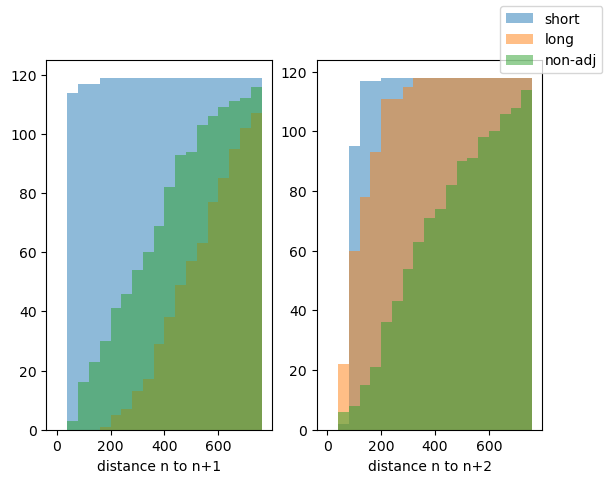

In [13]:
route_list = [short_route, long_route, non_adj_route]
label_list = ["short", "long", "non-adj"]
bins = np.arange(0, 800, 40)
fig, axs = plt.subplots(1, 2)
for route, label in zip(route_list, label_list):
    
    axs[0].hist(distances_all_steps(route, coms), cumulative=True, alpha=0.5, label=label, bins=bins)
    axs[1].hist(distances_n_steps(route, coms, n_steps=2), cumulative=True, alpha=0.5, bins=bins)
fig.legend()
axs[0].set_xlabel('distance n to n+1')
axs[1].set_xlabel('distance n to n+2')

In [14]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['non_adj'] = non_adj_route
sequence_dict['default'] = non_adj_route

In [15]:
grid_12by10 = StimSequenceSet(grid_stims, "grid_12by10", sequence_dict)

In [16]:
import pickle

In [17]:
with open(f'grid_12by10.pickle', 'wb') as file:
    pickle.dump(grid_12by10, file) 

In [18]:
##test pickle loading
with open(f'grid_12by10.pickle', 'rb') as file2:
    grid_new = pickle.load(file2)

In [19]:
grid_new.name

'grid_12by10'

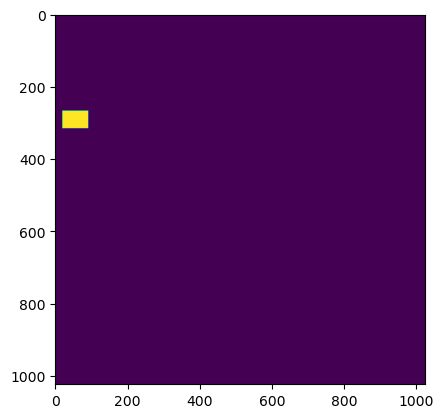

In [20]:
stim_pats = grid_new.image_sequence
plt.imshow(stim_pats[:,:,3])

In [21]:
coarse_grid = draw_all_grid_rects(n_cols=6, n_rows=5)

In [22]:
coms = image_sequence_com(coarse_grid)
coms = np.array(coms)

In [23]:
long_route = two_opt_long(coms,0.0001)

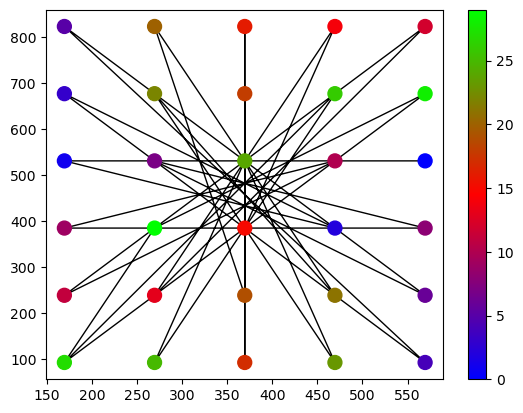

Route: [19 15 13 20  4 25  9 16 14 10 18  5 29  6 28 12 27  2 22  7 26  8 21  3
 17  1 23  0 24 11]

Distance: 15867.061967288835


In [24]:
plot_route(long_route, coms)

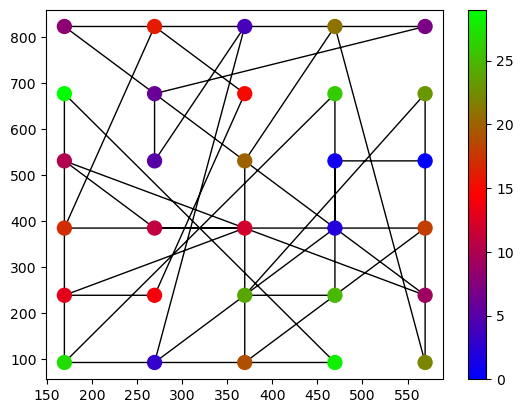

Route: [19 18 13  1 27 16 21 29 25  9 15 11 12  5  6 22 26 10 14  2 17 28  4 24
  7  8 23  0  3 20]

Distance: 11308.01970942822


In [25]:
non_adj_route = two_opt_one_two_step(coms, 0.0001)
plot_route(non_adj_route, coms)

In [26]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['non_adj'] = non_adj_route
sequence_dict['default'] = non_adj_route

In [27]:
grid_6by5 = StimSequenceSet(coarse_grid, "grid_6by5", sequence_dict)

In [28]:
with open(f'grid_6by5.pickle', 'wb') as file:
    pickle.dump(grid_6by5, file) 

In [29]:
def draw_all_grid_hex(n_cols, n_rows, img_w=1024, img_h=1024):
    n_stims = n_cols * n_rows
    grid_stims = np.zeros((img_w, img_h, n_stims), dtype = np.uint8)
    grid_i = 0
    for ic in np.arange(n_cols):
        for ir in np.arange(n_rows):
            stim = draw_hex(n_cols, n_rows, ic, ir)
            grid_stims[:, :, grid_i] = stim
            grid_i += 1
    return grid_stims

In [35]:
hex_grid_stims = draw_all_grid_hex(12, 0)

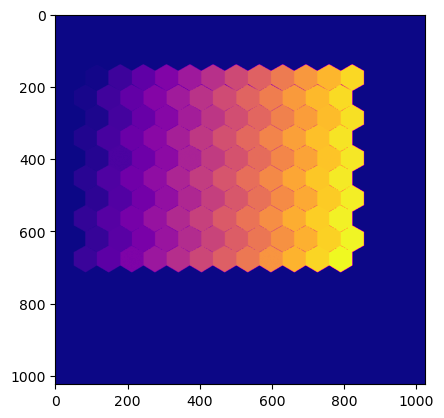

In [36]:
##check that hexys drawn as (h)expected
n_col, n_row = 12, 10
n_stims = n_col*n_row
hex_grid_stims = draw_all_grid_hex(n_col, n_row)
hex_grid_sum = np.zeros((1024,1024))
for i in np.arange(n_stims):
    hex_i = np.zeros((1024, 1024))
    hex_i = hex_grid_stims[:,:,i]
    hex_i = hex_i/255*(i+1)
    hex_i = hex_i.clip(max=255)
    
    hex_grid_sum += hex_i
    
plt.imshow(hex_grid_sum, cmap='plasma')

In [37]:
coms = image_sequence_com(hex_grid_stims)
coms = np.array(coms)

In [38]:
long_route = two_opt_long(coms,0.0001)


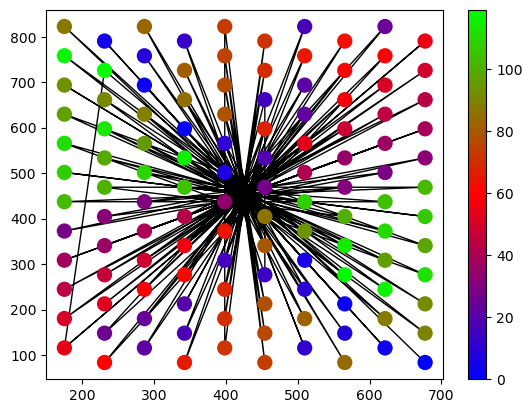

Route: [  9  83  27  92   8 111  36  64  17 102  26  74   6 113  35  95  34 116
  13  75  23  96   2  86  12 118  11  65  40  68  52  67  51  79  54  77
  41  78  30  89  42  66  53  99  20  88  31  87  32 109  10  98  21  76
   0 119  43  97  22 108   1 107  33 117  44 106   3  85  24 105  14 115
   4 114   5 104  15  94  25  84  45 103  16 112   7  93  55 110  18  82
  19  91  29  90  46  72  38  80  49  71  57  61  69  50  58  63  59  60
  56  62  48  70  39  81  47  73  28 100  37 101]

Distance: 61315.54715999792


In [39]:
plot_route(long_route, coms)

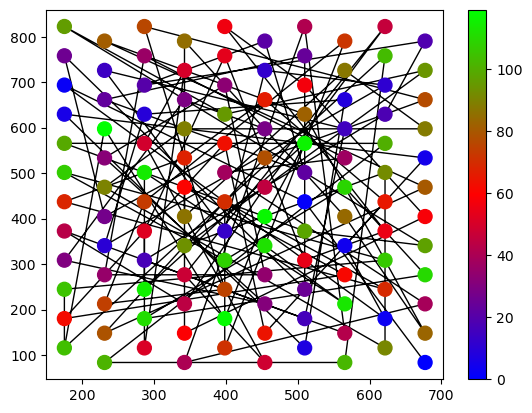

Route: [  9  56  90  18  47  79  80   6  97  82  41  98 105  44 101  87  16  32
  88 119  92 115  66  91 106  26 100  51  85  93  30  25  71  94  35  31
 102  77  64  29   3 116  17  40  23  65 118  33   5  72 103   2  42 104
  36  48 114  96  59  13  63  37  10  74  15  58  95  73  50  28  54   4
 117  52  21  24 112  99  75  11  69 111  86  19  57 113  53 107  89  83
  61   8  68  43 109  84 110  49  46  70  78   1   7 108   0  20  38  60
  34  67  39  12  45  27  62  22  76  55  14  81]

Distance: 44962.16645363229


In [40]:
non_adj_route = two_opt_one_two_step(coms, 0.0001)
plot_route(non_adj_route, coms)

In [41]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['non_adj'] = non_adj_route
sequence_dict['default'] = non_adj_route

In [42]:
hex_12by10 = StimSequenceSet(hex_grid_stims, "hex_12by10", sequence_dict)

In [43]:
with open(f'hex_12by10.pickle', 'wb') as file:
    pickle.dump(hex_12by10, file) 